<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/Quantum_Support_Vector_Machine_on_different_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data set

Aim is to classify the Breast Cancer Wisconsin (Diagnosis) Data set. The datast consists in 569 training samples, with each 32 attributes such as the perimeter, the texture, the area, etc. The diagnosis of these data can be malginant or benign.

For the sake of simplicity, which will be particularly relevant for the quantum enhanced version of the algorithm, we do a dimensional reduction of our data from 32 attributes to 2, with the help of a principal component analysis (PCA). Such unsupervised algorithm finds the principal axes of the data with a singular value decomposition.

In [3]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def load_dataset(dataset_name):
    """Loads the specified dataset from sklearn.datasets"""
    if dataset_name == 'breast_cancer':
        return datasets.load_breast_cancer()
    elif dataset_name == 'iris':
        return datasets.load_iris()
    elif dataset_name == 'wine':
        return datasets.load_wine()
    elif dataset_name == 'digits':
        return datasets.load_digits()
    else:
        raise ValueError(f"Dataset '{dataset_name}' is not supported.")

def process_data(dataset_name, training_size,test_size, n, PLOT_DATA=True):
    class_labels =[]

    #Load dataset
    dataset = load_dataset(dataset_name)

    #set class labels based on the dataset
    if dataset_name == 'breast_cancer':
      class_labels = [r'Malignant', r'Benign']
    elif dataset_name == 'iris':
      class_labels = [r'Setosa', r'Versicolour', r'Virginica']
    elif dataset_name == 'wine':
      class_labels = [r'Class 1', r'Class 2', r'Class 3']
    elif dataset_name == 'digits':
      class_labels = [r'0', r'1', r'2', r'3', r'4', r'5', r'6', r'7', r'8', r'9']

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    # Split the dataset into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    # Plot data if requested
    if PLOT_DATA and n == 2:  # Only plot if the data is reduced to 2 dimensions
        for k in range(len(class_labels)):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            plt.scatter(x_axis_data, y_axis_data, label=class_labels[k])

        plt.title(f"{dataset_name.capitalize()} Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()

    return X_train, training_input, test_input, class_labels




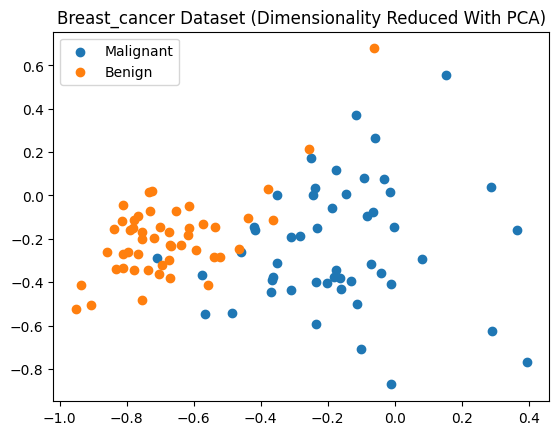

In [6]:
X_train, training_input, test_input, class_labels = process_data('breast_cancer', training_size=50, test_size=10, n=2)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class svm_utils:

	def make_meshgrid(x, y, h=.02):
	    """Create a mesh of points to plot in

	    Parameters
	    ----------
	    x: data to base x-axis meshgrid on
	    y: data to base y-axis meshgrid on
	    h: stepsize for meshgrid, optional

	    Returns
	    -------
	    xx, yy : ndarray
	    """
	    x_min, x_max = x.min() - 1, x.max() + 1
	    y_min, y_max = y.min() - 1, y.max() + 1
	    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
		                 np.arange(y_min, y_max, h))
	    return xx, yy


	def plot_contours(ax, clf, xx, yy, **params):
	    """Plot the decision boundaries for a classifier.

	    Parameters
	    ----------
	    ax: matplotlib axes object
	    clf: a classifier
	    xx: meshgrid ndarray
	    yy: meshgrid ndarray
	    params: dictionary of params to pass to contourf, optional
	    """
	    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
	    Z = Z.reshape(xx.shape)
	    out = ax.contourf(xx, yy, Z, **params)
	    return out

In [8]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512546 sha256=f6f99b687ca09c319f7d99b9563dc21a0ee6d7b723371558e3d2588ea7802b70
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d5

In [9]:
import numpy as np
#from dataset import breast_cancer
from sklearn.datasets import make_blobs
#from qiskit_machine_learning.datasets
# import split_dataset_to_data_and_labels from qiskit_machine_learning.utils.dataset_helper
from sklearn import svm
#from utils import svm_utils
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

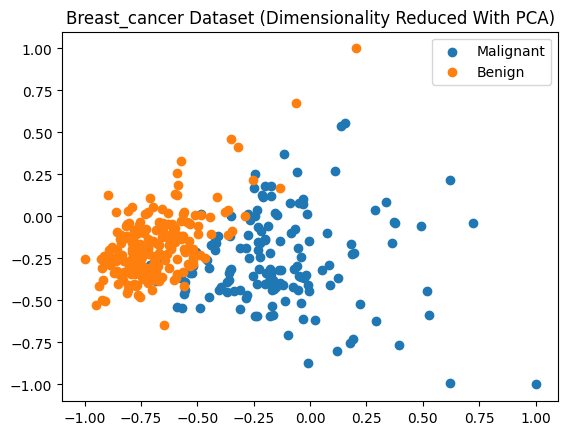

Training data shape: (349, 2)
Testing data shape: (49, 2)


In [14]:
# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = process_data('breast_cancer', training_dataset_size, testing_dataset_size, n)
# Split the dataset into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.target, test_size=0.3, random_state=109)

# Split dataset into data and labels
data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")

In [15]:
# Check shape to ensure 2D structure
print(data_train.shape)

(349, 2)


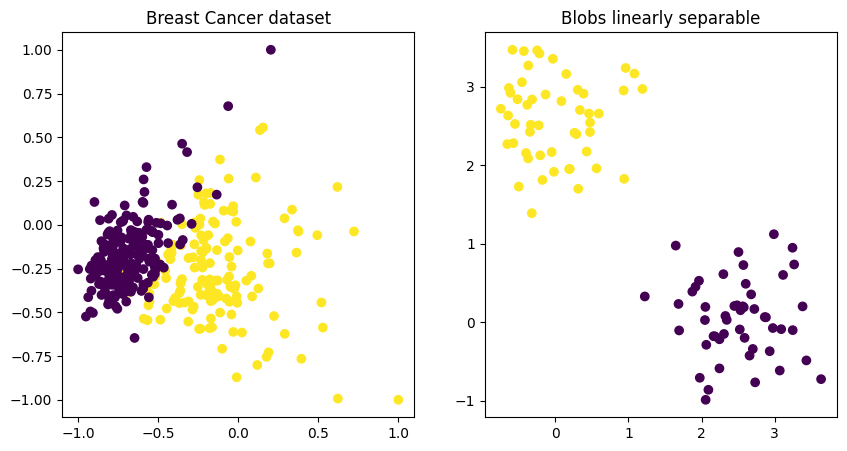

In [16]:
# We use the function of scikit learn to generate linearly separable blobs
centers = [(2.5,0),(0,2.5)]
x, y = make_blobs(n_samples=100, centers=centers, n_features=2,random_state=0,cluster_std=0.5)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');

ax[1].scatter(x[:,0],x[:,1],c=y)
ax[1].set_title('Blobs linearly separable');

In [17]:
model= svm.LinearSVC()
model.fit(data_train, data_train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

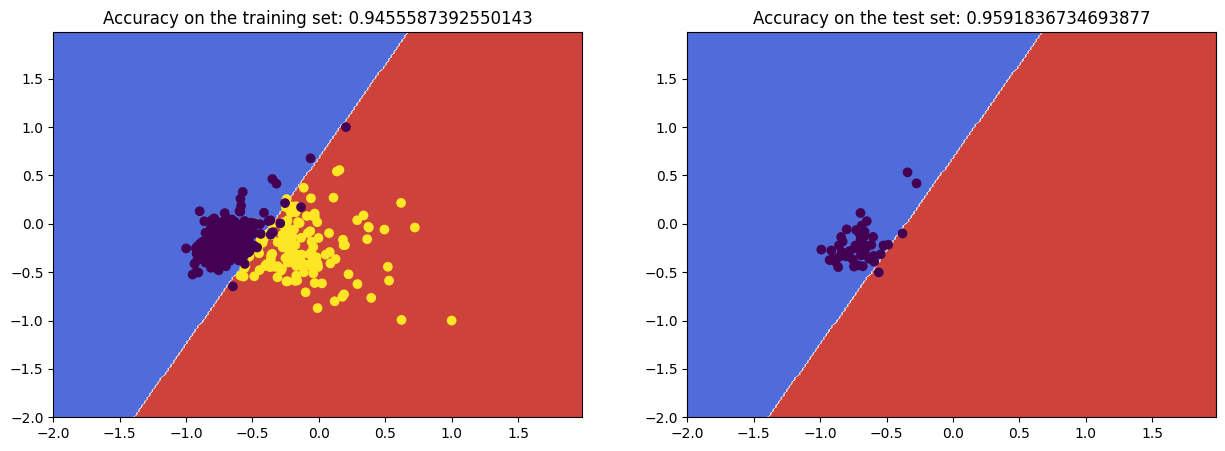

In [18]:
accuracy_train = model.score(data_train, data_train_labels)
accuracy_test = model.score(data_test, data_test_labels)


X0, X1 = data_train[:, 0], data_train[:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[:,0], data_train[:,1], c=data_train_labels)
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[:,0], data_test[:,1], c=data_test_labels)
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

In [19]:
from sklearn.metrics import classification_report

print(classification_report (data_test_labels, model.predict(data_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        49
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96        49
   macro avg       0.50      0.48      0.49        49
weighted avg       1.00      0.96      0.98        49



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
from sklearn.svm import SVC
for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel, decision_function_shape="ovr")
    classical_svc.fit(data_train, data_train_labels)
    classical_score = classical_svc.score(data_test, data_test_labels)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.96
poly kernel classification test score:  0.94
rbf kernel classification test score:  0.96
sigmoid kernel classification test score:  0.51


Qiskit QSVC

In [21]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

from IPython.display import clear_output
clear_output()

from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345


In [47]:

from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Function to select feature map based on a given method
def choose_feature_map(method, feature_dimension=2, reps=2):
    if method == 'ZZFeatureMap':
        return ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement='linear')
    elif method == 'PauliFeatureMap':
        return PauliFeatureMap(feature_dimension=feature_dimension, reps=reps, paulis=['Z', 'X'])
    elif method == 'ZFeatureMap':
        return ZFeatureMap(feature_dimension=feature_dimension, reps=reps)
    #elif method == 'RawFeatureVector':
        #return  RawFeatureVector(feature_dimension = 2**np.log2(feature_dimension)).bind_parameters(np.array([1, -1])*1/np.sqrt(2)) # Initializing and binding RFV to some random state
    else:
        raise ValueError("Unknown feature map method")

#RawFeatureVector

#We will be using RFV, which is an amplitude encoding PQC, to encode the iris features into quantum states. Unlike angle encoding, amplitude encoding only
#requires Log2(N) qubits, where N is the number of features in our dataset, which means we can encode the two PCs using one qubit.

# Example list of feature map options
feature_map_options = ['ZZFeatureMap', 'PauliFeatureMap', 'ZFeatureMap', 'TwoLocal']

'''
# Create a list of quantum kernels based on different feature maps
quantum_kernels = {}
for method in feature_map_options:
    quantum_kernels[method] = get_quantum_kernel(method, feature_dimension=2, reps=2)

# Print the quantum kernels created
for method, kernel in quantum_kernels.items():
    print(f"Quantum kernel created with feature map: {method}")

'''
# Choosing a feature map dynamically
chosen_method = 'ZZFeatureMap'  # You can modify this to try different methods
feature_map = choose_feature_map(chosen_method, feature_dimension=2, reps=2)

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler) #evaluate the overlap between quantum state

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# Now `adhoc_kernel` uses the chosen feature map
print(f"Feature map selected: {chosen_method}")

Feature map selected: ZFeatureMap


<ipython-input-47-c73074288ca9>:42: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


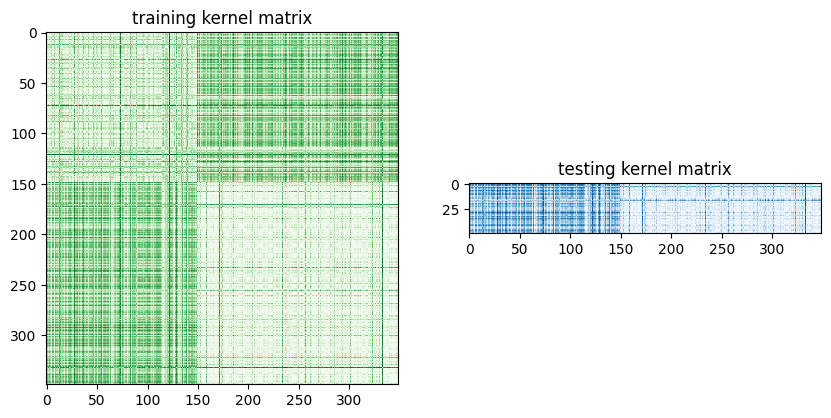

In [48]:
matrix_train = quantum_kernel.evaluate(x_vec=data_train)
matrix_test = quantum_kernel.evaluate(x_vec=data_test, y_vec=data_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Greens_r')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Blues_r')
axs[1].set_title("testing kernel matrix")
plt.show()

In [34]:
#use classical kernels and sklearn svm
!pip install qiskit-aer # Install the qiskit-aer package

from qiskit_aer import StatevectorSimulator
backend = StatevectorSimulator(precision='double')
backend.available_devices()

('CPU',)

In [26]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=quantum_kernel)

qsvc.fit(data_train, data_train_labels)

qsvc_score = qsvc.score(data_test, data_test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9183673469387755
